# Register Two Point Sets

Similar to image registration, an n-dimensional "moving" point set may be resampled to align with a "fixed" point set. An ITK point set metric may be employed with an ITK optimizer in order to register the two sets.

In this example we create two `itk.PointSet` representations with an arbitrary offset and select parameters to align them with a `TranslationTransform`. We use the `JensenHavrdaCharvatTsallisPointSetToPointSetMetricv4` class to quantify the difference between point sets and the `GradientDescentOptimizerv4` class to iteratively reduce this difference by modifying transform parameters. Our example also includes sample code visualizing the parameter surface with `matplotlib` and `itkwidgets` as well as a sample hyperparameter search to optimize gradient descent performance.

In [1]:
import os
import sys
import itertools
from math import pi, sin, cos, sqrt

import matplotlib.pyplot as plt
import numpy as np

import itk
from itkwidgets import view


### Construct Two Point Sets

In [2]:
# Generate two circles with a small offset
def make_circles(dimension: int = 2, offset: list = None):

    PointSetType = itk.PointSet[itk.F, dimension]

    RADIUS = 100

    if not offset or len(offset) != dimension:
        offset = [2.0] * dimension

    fixed_points = PointSetType.New()
    moving_points = PointSetType.New()
    fixed_points.Initialize()
    moving_points.Initialize()

    count = 0
    step = 0.1
    for count in range(0, int(2 * pi / step) + 1):

        theta = count * step

        fixed_point = list()
        fixed_point.append(RADIUS * cos(theta))
        for dim in range(1, dimension):
            fixed_point.append(RADIUS * sin(theta))
        fixed_points.SetPoint(count, fixed_point)

        moving_point = [fixed_point[dim] + offset[dim] for dim in range(0, dimension)]
        moving_points.SetPoint(count, moving_point)

    return fixed_points, moving_points


In [3]:
POINT_SET_OFFSET = [15.0, 15.0]
fixed_set, moving_set = make_circles(offset=POINT_SET_OFFSET)


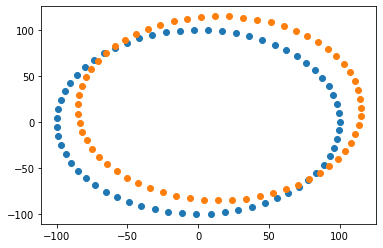

In [4]:
# Visualize point sets with matplotlib

fig = plt.figure()
ax = plt.axes()

n_points = fixed_set.GetNumberOfPoints()
ax.scatter(
    [fixed_set.GetPoint(i)[0] for i in range(0, n_points)],
    [fixed_set.GetPoint(i)[1] for i in range(0, n_points)],
)
ax.scatter(
    [moving_set.GetPoint(i)[0] for i in range(0, n_points)],
    [moving_set.GetPoint(i)[1] for i in range(0, n_points)],
)


### Run Gradient Descent Optimization

We will quantify the point set offset with `JensenHavrdaCharvatTsallisPointSetToPointSetMetricv4` and minimize the metric value over 10 gradient descent iterations. 

In [5]:
ExhaustiveOptimizerType = itk.ExhaustiveOptimizerv4[itk.D]


In [6]:
dim = 2

# Define translation parameters to update iteratively
TransformType = itk.TranslationTransform[itk.D, dim]
transform = TransformType.New()
transform.SetIdentity()


In [7]:
PointSetType = type(fixed_set)

# Define a metric to reflect the difference between point sets
PointSetMetricType = itk.JensenHavrdaCharvatTsallisPointSetToPointSetMetricv4[PointSetType]
metric = PointSetMetricType.New(
    FixedPointSet=fixed_set,
    MovingPointSet=moving_set,
    MovingTransform=transform,
    PointSetSigma=5.0,
    KernelSigma=10.0,
    UseAnisotropicCovariances=False,
    CovarianceKNeighborhood=5,
    EvaluationKNeighborhood=10,
    Alpha=1.1,
)
metric.Initialize()


In [8]:
# Define an estimator to help determine step sizes along each transform parameter2
ShiftScalesType = itk.RegistrationParameterScalesFromPhysicalShift[PointSetMetricType]
shift_scale_estimator = ShiftScalesType.New(
    Metric=metric, VirtualDomainPointSet=metric.GetVirtualTransformedPointSet(), TransformForward=True
)


In [9]:
max_iterations = 10

# Define the gradient descent optimzer
OptimizerType = itk.GradientDescentOptimizerv4Template[itk.D]
optimizer = OptimizerType.New(
    Metric=metric,
    NumberOfIterations=max_iterations,
    ScalesEstimator=shift_scale_estimator,
    MaximumStepSizeInPhysicalUnits=8.0,
    MinimumConvergenceValue=-1,
    DoEstimateLearningRateAtEachIteration=False,
    DoEstimateLearningRateOnce=True,
    ReturnBestParametersAndValue=True,
)


In [10]:
iteration_data = dict()

# Track gradient descent iterations with observers
def print_iteration():
    print(
        f"It: {optimizer.GetCurrentIteration()}"
        f" metric value: {optimizer.GetCurrentMetricValue():.6f} "
        # f' transform position: {list(optimizer.GetCurrentPosition())}'
        f" learning rate: {optimizer.GetLearningRate()}"
    )


def log_iteration():
    iteration_data[optimizer.GetCurrentIteration() + 1] = list(optimizer.GetCurrentPosition())


optimizer.AddObserver(itk.AnyEvent(), print_iteration)
optimizer.AddObserver(itk.IterationEvent(), log_iteration)

# Set first value to default transform position
iteration_data[0] = list(optimizer.GetCurrentPosition())


In [11]:
# Run optimization and print out results
optimizer.StartOptimization()

print(f"Number of iterations: {optimizer.GetCurrentIteration() - 1}")
print(f"Moving-source final value: {optimizer.GetCurrentMetricValue()}")
print(f"Moving-source final position: {list(optimizer.GetCurrentPosition())}")
print(f"Optimizer scales: {list(optimizer.GetScales())}")
print(f"Optimizer learning rate: {optimizer.GetLearningRate()}")
print(f"Stop reason: {optimizer.GetStopConditionDescription()}")


It: 0 metric value: 0.000000  learning rate: 1.0
It: 0 metric value: -0.043464  learning rate: 5594.753388446298
It: 1 metric value: -0.054787  learning rate: 5594.753388446298
It: 2 metric value: -0.062597  learning rate: 5594.753388446298
It: 3 metric value: -0.064588  learning rate: 5594.753388446298
It: 4 metric value: -0.064807  learning rate: 5594.753388446298
It: 5 metric value: -0.064815  learning rate: 5594.753388446298
It: 6 metric value: -0.064815  learning rate: 5594.753388446298
It: 7 metric value: -0.064815  learning rate: 5594.753388446298
It: 8 metric value: -0.064815  learning rate: 5594.753388446298
It: 9 metric value: -0.064815  learning rate: 5594.753388446298
It: 10 metric value: -0.064815  learning rate: 5594.753388446298
Number of iterations: 9
Moving-source final value: -0.06481531061643396
Moving-source final position: [15.000412861069881, 14.99997463945473]
Optimizer scales: [1.0000000000010232, 1.0000000000010232]
Optimizer learning rate: 5594.753388446298
St

### Resample Moving Point Set

In [12]:
moving_inverse = metric.GetMovingTransform().GetInverseTransform()
fixed_inverse = metric.GetFixedTransform().GetInverseTransform()


In [13]:
transformed_fixed_set = PointSetType.New()
transformed_moving_set = PointSetType.New()

for n in range(0, metric.GetNumberOfComponents()):
    transformed_moving_point = moving_inverse.TransformPoint(moving_set.GetPoint(n))
    transformed_moving_set.SetPoint(n, transformed_moving_point)

    transformed_fixed_point = fixed_inverse.TransformPoint(fixed_set.GetPoint(n))
    transformed_fixed_set.SetPoint(n, transformed_fixed_point)


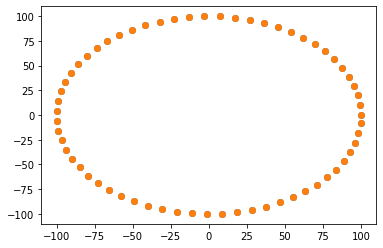

In [14]:
# Compare fixed point set with resampled moving point set to see alignment

fig = plt.figure()
ax = plt.axes()

n_points = fixed_set.GetNumberOfPoints()
ax.scatter(
    [fixed_set.GetPoint(i)[0] for i in range(0, n_points)],
    [fixed_set.GetPoint(i)[1] for i in range(0, n_points)],
)
ax.scatter(
    [transformed_moving_set.GetPoint(i)[0] for i in range(0, n_points)],
    [transformed_moving_set.GetPoint(i)[1] for i in range(0, n_points)],
)


# Visualize Gradient Descent

We can use the ITK `ExhaustiveOptimizerv4` class to view how the optimizer moved along the surface defined by the transform parameters and metric.

In [15]:
# Set up the new optimizer

# Create a new transform and metric for analysis
transform = TransformType.New()
transform.SetIdentity()

metric = PointSetMetricType.New(
    FixedPointSet=fixed_set,
    MovingPointSet=moving_set,
    MovingTransform=transform,
    PointSetSigma=5,
    KernelSigma=10.0,
    UseAnisotropicCovariances=False,
    CovarianceKNeighborhood=5,
    EvaluationKNeighborhood=10,
    Alpha=1.1,
)
metric.Initialize()

# Create a new observer to map out the parameter surface
optimizer.RemoveAllObservers()
optimizer = ExhaustiveOptimizerType.New(Metric=metric)

# Use observers to collect points on the surface
param_space = dict()


def log_exhaustive_iteration():
    param_space[tuple(optimizer.GetCurrentPosition())] = optimizer.GetCurrentValue()


optimizer.AddObserver(itk.IterationEvent(), log_exhaustive_iteration)

# Collect a moderate number of steps along each transform parameter
step_count = 25
optimizer.SetNumberOfSteps([step_count, step_count])

# Step a reasonable distance along each transform parameter
scales = optimizer.GetScales()
scales.SetSize(2)

scale_size = 1.0
scales.SetElement(0, scale_size)
scales.SetElement(1, scale_size)

optimizer.SetScales(scales)


In [16]:
optimizer.StartOptimization()
print(
    f"MinimumMetricValue: {optimizer.GetMinimumMetricValue():.4f}\t"
    f"MaximumMetricValue: {optimizer.GetMaximumMetricValue():.4f}\n"
    f"MinimumMetricValuePosition: {list(optimizer.GetMinimumMetricValuePosition())}\t"
    f"MaximumMetricValuePosition: {list(optimizer.GetMaximumMetricValuePosition())}\n"
    f"StopConditionDescription: {optimizer.GetStopConditionDescription()}\t"
)


MinimumMetricValue: -0.0648	MaximumMetricValue: -0.0153
MinimumMetricValuePosition: [15.0, 15.0]	MaximumMetricValuePosition: [-25.0, -25.0]
StopConditionDescription: ExhaustiveOptimizerv4: Completed sampling of parametric space of size 2	


In [17]:
# Reformat gradient descent data to overlay on the plot
descent_x_vals = [iteration_data[i][0] for i in range(0, len(iteration_data))]
descent_y_vals = [iteration_data[i][1] for i in range(0, len(iteration_data))]


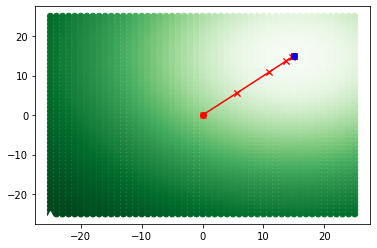

In [18]:
# Plot the surface, extrema, and gradient descent data in a matplotlib scatter plot

fig = plt.figure()
ax = plt.axes()

ax.scatter(
    [x for (x, y) in param_space.keys()],
    [y for (x, y) in param_space.keys()],
    c=list(param_space.values()),
    cmap="Greens",
    zorder=1,
)
ax.plot(
    optimizer.GetMinimumMetricValuePosition()[0], optimizer.GetMinimumMetricValuePosition()[1], "kv"
)
ax.plot(
    optimizer.GetMaximumMetricValuePosition()[0], optimizer.GetMaximumMetricValuePosition()[1], "w^"
)

for i in range(0, len(iteration_data)):
    ax.plot(descent_x_vals[i : i + 2], descent_y_vals[i : i + 2], "rx-")
ax.plot(descent_x_vals[0], descent_y_vals[0], "ro")
ax.plot(descent_x_vals[len(iteration_data) - 1], descent_y_vals[len(iteration_data) - 1], "bo")


We can also view and export the surface as an image using `itkwidgets`.

In [19]:
x_vals = list(set(x for (x, y) in param_space.keys()))
y_vals = list(set(y for (x, y) in param_space.keys()))

x_vals.sort()
y_vals.sort(reverse=True)
array = np.array([[param_space[(x, y)] for x in x_vals] for y in y_vals])

image_view = itk.GetImageViewFromArray(array)


In [20]:
view(image_view)


Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD2; pro…

# Hyperparameter Search

In order to find adequate results with different transforms, metrics, and optimizers it is often useful to compare results across variations in hyperparameters. In the case of this example it was necessary to evaluate performance for different values of the `JensenHavrdaCharvatTsallisPointSetToPointSetMetricv4.PointSetSigma` parameter and `GradientDescentOptimizerv4.DoEstimateLearningRate` parameters. Gradient descent iteration data was plotted along 2D scatter plots to compare and select the hyperparameter combination yielding the best performance.

In [21]:
# Index values for gradient descent logging

FINAL_OPT_INDEX = 0
DESCENT_DATA_INDEX = 1


In [22]:
hyper_data = dict()
final_optimizers = dict()

# sigma must be sufficiently large to avoid negative entropy results
point_set_sigmas = (1.0, 2.5, 5.0, 10.0, 20.0, 50.0)

# Compare performance with repeated or one-time learning rate estimation
estimate_rates = [(False, False), (False, True), (True, False)]


In [23]:
# Run gradient descent optimization for each combination of hyperparameters

for trial_values in itertools.product(point_set_sigmas, estimate_rates):
    hyper_data[trial_values] = dict()

    (point_set_sigma, est_rate) = trial_values

    fixed_set, moving_set = make_circles(offset=POINT_SET_OFFSET)

    transform = TransformType.New()
    transform.SetIdentity()

    metric = PointSetMetricType.New(
        FixedPointSet=fixed_set,
        MovingPointSet=moving_set,
        PointSetSigma=point_set_sigma,
        KernelSigma=10.0,
        UseAnisotropicCovariances=False,
        CovarianceKNeighborhood=5,
        EvaluationKNeighborhood=10,
        MovingTransform=transform,
        Alpha=1.1,
    )
    shift_scale_estimator = ShiftScalesType.New(
        Metric=metric, VirtualDomainPointSet=metric.GetVirtualTransformedPointSet()
    )

    metric.Initialize()
    optimizer = OptimizerType.New(
        Metric=metric,
        NumberOfIterations=100,
        MaximumStepSizeInPhysicalUnits=3.0,
        MinimumConvergenceValue=-1,
        DoEstimateLearningRateOnce=est_rate[0],
        DoEstimateLearningRateAtEachIteration=est_rate[1],
        LearningRate=1e6,  # Ignored if either est_rate argument is True
        ReturnBestParametersAndValue=False,
    )

    optimizer.SetScalesEstimator(shift_scale_estimator)

    def log_hyper_iteration_data():
        hyper_data[trial_values][optimizer.GetCurrentIteration()] = round(
            optimizer.GetCurrentMetricValue(), 8
        )

    optimizer.AddObserver(itk.IterationEvent(), log_hyper_iteration_data)

    optimizer.StartOptimization()

    final_optimizers[trial_values] = optimizer


In [24]:
# Print results for each set of hyperparameters

print("PS_sigma\test once/each:\tfinal index\tfinal metric")
for trial_values in itertools.product(point_set_sigmas, estimate_rates):

    print(
        f"{trial_values[0]}\t\t{trial_values[1]}:\t\t"
        f"{final_optimizers[trial_values].GetCurrentIteration()}\t"
        f"{final_optimizers[trial_values].GetCurrentMetricValue():10.8f}"
    )


PS_sigma	est once/each:	final index	final metric
1.0		(False, False):		100	0.00000000
1.0		(False, True):		100	-0.01074471
1.0		(True, False):		100	-0.01061929
2.5		(False, False):		100	0.00000000
2.5		(False, True):		100	-0.07264293
2.5		(True, False):		100	-0.06137661
5.0		(False, False):		100	0.00000000
5.0		(False, True):		100	-0.06481184
5.0		(True, False):		100	-0.06481531
10.0		(False, False):		100	0.00000000
10.0		(False, True):		100	-0.06039311
10.0		(True, False):		100	-0.06039382
20.0		(False, False):		100	-0.04939961
20.0		(False, True):		100	-0.05628143
20.0		(True, False):		100	-0.05628171
50.0		(False, False):		100	-0.04947632
50.0		(False, True):		100	-0.04947578
50.0		(True, False):		100	-0.04947632


We can use `matplotlib` subplots and bar graphs to compare gradient descent performance and final metric values for each set of hyperparameters. In this example we see that estimating the learning rate once typically gives the best performance over time, while estimating the learning rate at each iteration can prevent gradient descent from converging efficiently. The hyperparameter set giving the best and most consistent metric value is that with `PointSetSigma=5.0` and `DoEstimateLearningRateOnce=True`, which are the values we have used in this notebook.

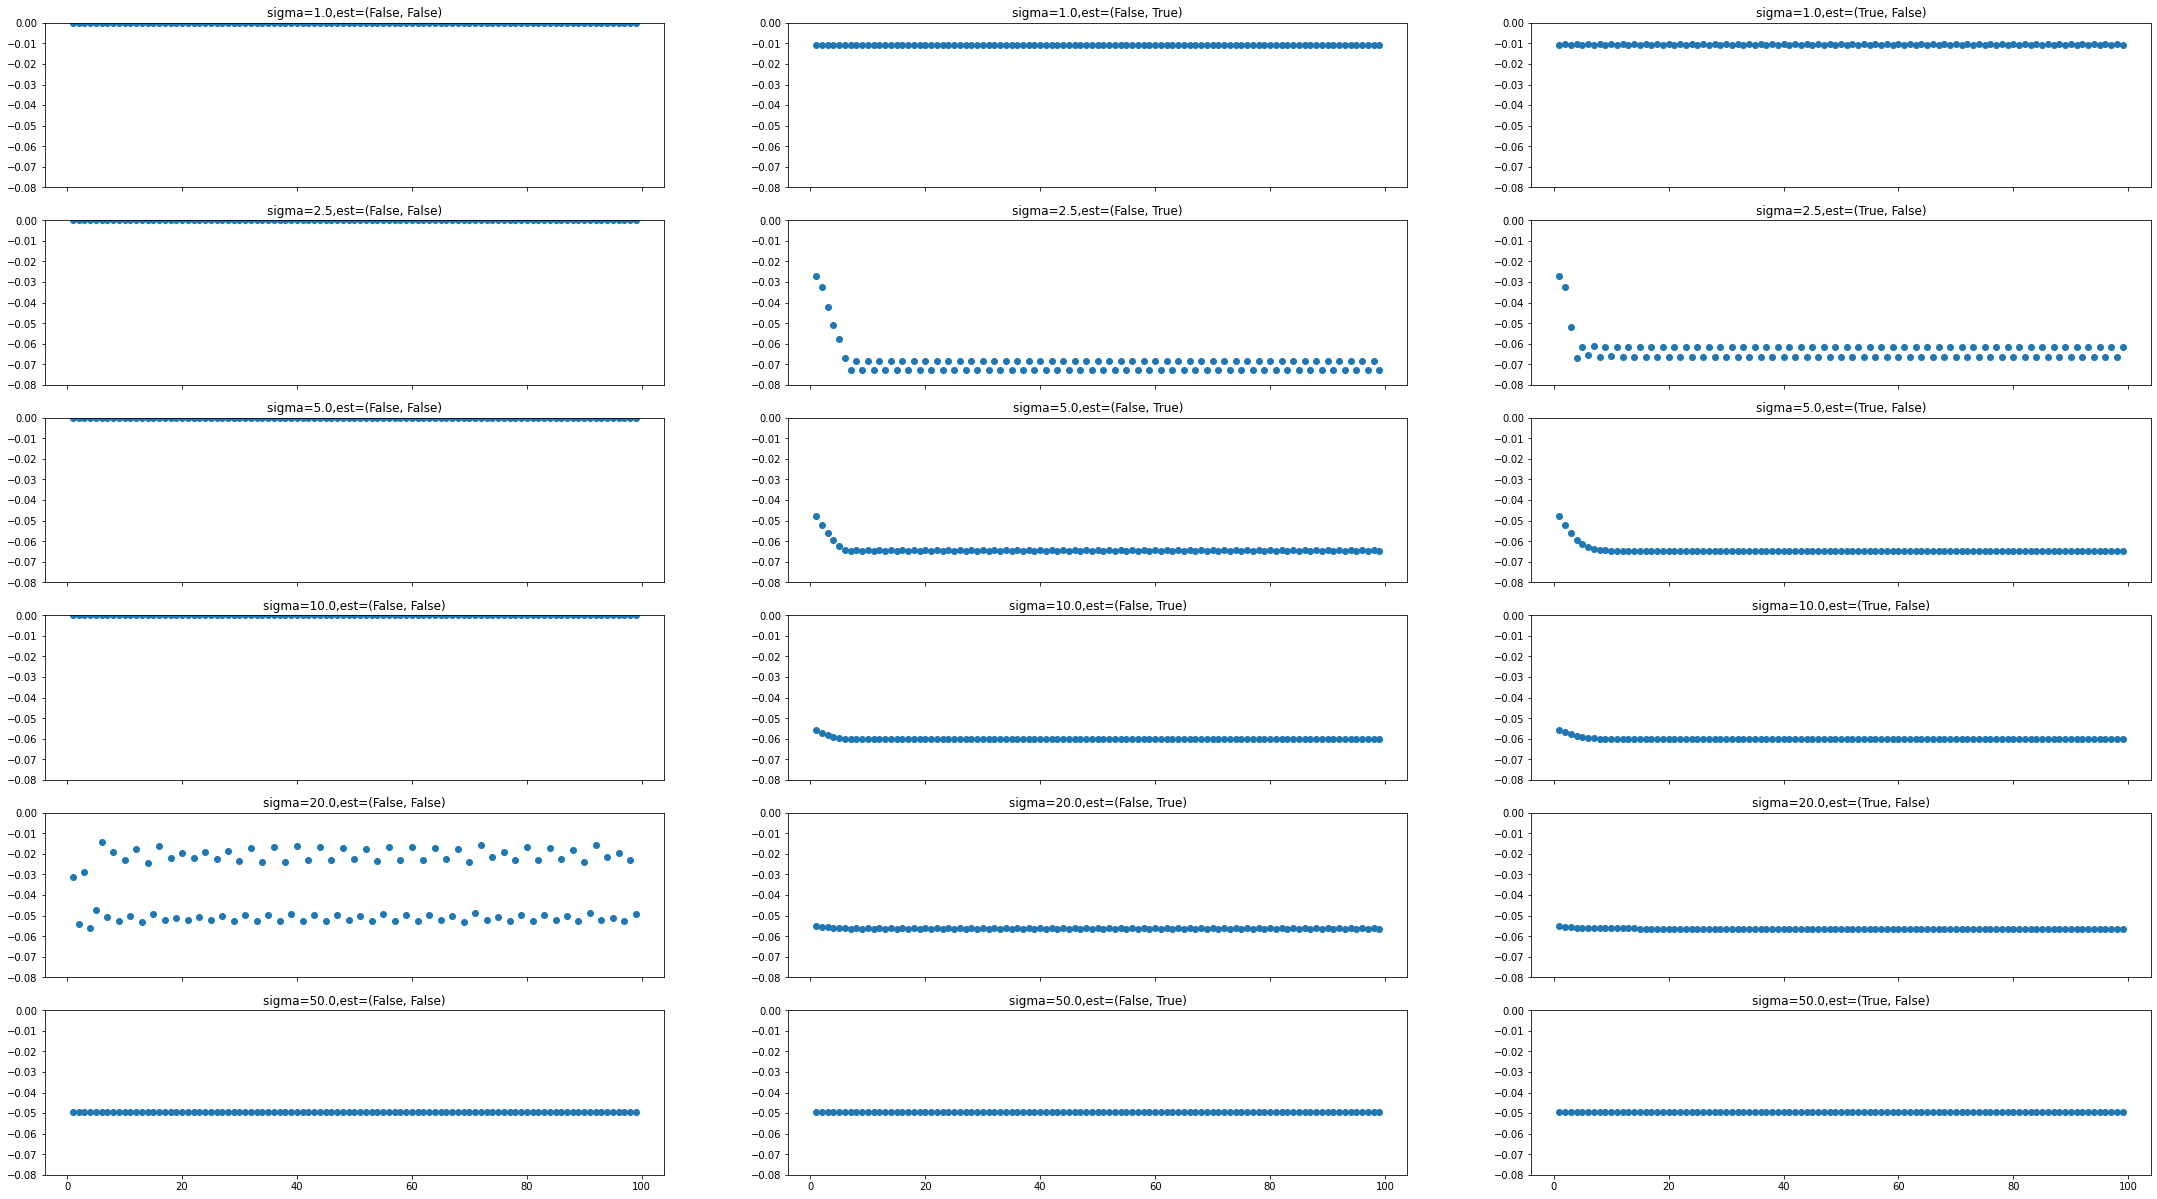

In [25]:
# Visualize metric over gradient descent iterations as matplotlib subplots.

f, axn = plt.subplots(len(point_set_sigmas), len(estimate_rates), sharex=True)

for (i, j) in [(i, j) for i in range(0, len(point_set_sigmas)) for j in range(0, len(estimate_rates))]:
    axn[i, j].scatter(
        x=list(hyper_data[point_set_sigmas[i], estimate_rates[j]].keys())[1:],
        y=list(hyper_data[point_set_sigmas[i], estimate_rates[j]].values())[1:],
    )
    axn[i, j].set_title(f"sigma={point_set_sigmas[i]},est={estimate_rates[j]}")
    axn[i, j].set_ylim(-0.08, 0)

plt.subplots_adjust(top=5, bottom=1, right=5)
plt.show()


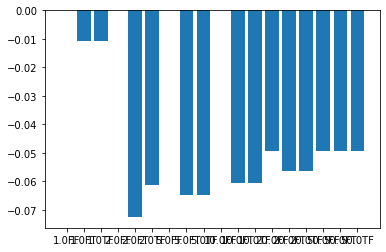

In [26]:
# Compare final metric magnitudes

fig = plt.figure()
ax = fig.gca()

labels = [
    f'{round(sig,0)}{"T" if est0 else "F"}{"T" if est1 else "F"}'
    for (sig, (est0, est1)) in itertools.product(point_set_sigmas, estimate_rates)
]

vals = [
    final_optimizers[trial_values].GetCurrentMetricValue()
    for trial_values in itertools.product(point_set_sigmas, estimate_rates)
]

ax.bar(labels, vals)
plt.show()
